In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cartopy.crs as ccrs
from shapely.geometry import box, mapping
import pyproj
import geopandas as gpd

from renewable_data_load import *
from climakitae.util.utils import clip_to_shapefile

/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


This notebook takes in individual timeseries of droughts as a binary mask and analyzes the days where there are co-incident events.

In [4]:
def load_drought_mask(resource, module, domain, variable, simulation, gwl, data_dir="../../data/drought_masks"):
    """
    Load a drought mask from zarr store.
    
    Parameters
    ----------
    resource : str
        Resource type ('pv' or 'windpower')
    module : str
        Module type ('utility', 'distributed', 'onshore', 'offshore')
    domain : str
        Domain ('d02' or 'd03')
    variable : str
        Variable ('cf' or 'gen')
    simulation : str
        Climate model simulation name
    gwl : float
        Global warming level (0.8, 1.5, 2.0, 3.0, etc.)
    data_dir : str or Path
        Directory containing drought mask files
        
    Returns
    -------
    xr.DataArray
        Drought mask (1 = drought, 0 = no drought)
    """
    mask_file = f"{resource}_{module}_{domain}_{variable}_{simulation}_gwl{gwl}_drought_mask_only.zarr"
    mask_path = Path(data_dir) / mask_file
    
    if not mask_path.exists():
        raise FileNotFoundError(f"Drought mask not found: {mask_path}")
    
    # Open zarr store with consolidated metadata
    ds = xr.open_zarr(mask_path, consolidated=True)
    
    return ds['drought_mask']

In [15]:
simulation = "ec-earth3"
reference_gwl = 0.8
target_gwl = 2.0
# Data directory
data_dir = Path("../../data/drought_masks")

offshore_mask = load_drought_mask(
    resource="windpower",
    module="offshore",
    domain='d03',
    variable='cf',
    simulation=simulation,
    gwl=target_gwl,
    data_dir=data_dir
)

In [20]:
def apply_ocean_mask(da, resolution='50m'):
    """
    Apply ocean mask to keep only ocean grid cells.
    
    Parameters
    ----------
    da : xr.DataArray
        Input data array with 'lat' and 'lon' coordinates
    resolution : str
        Resolution of Natural Earth land feature ('10m', '50m', '110m')
        
    Returns
    -------
    xr.DataArray
        Masked data array with land areas set to NaN
    """
    from cartopy.io.shapereader import natural_earth
    from shapely.geometry import Point
    from shapely.ops import unary_union
    
    # Get land geometries from Natural Earth
    land_geom = natural_earth(resolution=resolution, category='physical', name='land')
    land_shapes = gpd.read_file(land_geom)
    
    # Combine all land polygons into single geometry
    land_union = unary_union(land_shapes.geometry)
    
    # Create mask: True for ocean points, False for land
    lons, lats = np.meshgrid(da.lon.values, da.lat.values)
    ocean_mask = np.zeros_like(lons, dtype=bool)
    
    for i in range(lons.shape[0]):
        for j in range(lons.shape[1]):
            point = Point(lons[i, j], lats[i, j])
            ocean_mask[i, j] = not land_union.contains(point)
    
    # Apply mask to data
    masked_da = da.where(ocean_mask)
    
    return masked_da

In [ ]:
test = apply_ocean_mask(offshore_mask.isel(time=400))

/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


In [ ]:
teot()st.p

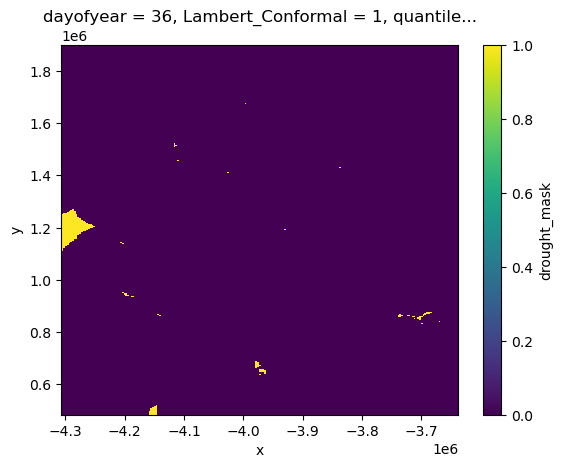

In [ ]:
aoffshore_mask.isel(time=400).plot()

In [ ]:
# Analysis parameters
domain = "d03"
variable = "cf"


# Available simulations
simulations = ["mpi-esm1-2-hr", "miroc6", "taiesm1", "ec-earth3"]

In [ ]:
def find_coincident_events([list_of_timeseries],[thresholds]):

In [13]:
pv_drought = xr.open_dataarray("/Users/work/Code/renewable-analysis/notebooks/concurrent_drought/PG&E_ec-earth3_pv_utility_gwl0.8_drought_area_fraction.nc")
wind_drought = xr.open_dataarray("/Users/work/Code/renewable-analysis/notebooks/concurrent_drought/PG&E_ec-earth3_windpower_onshore_gwl0.8_drought_area_fraction.nc")


In [14]:
pv_drought.name = 'pv_drought_fraction'
wind_drought.name = 'wind_drought_fraction'


In [15]:
pv_mask = xr.where(pv_drought > 0.3,1,0)
wind_mask = xr.where(wind_drought > 0.2,1,0)

coincident_mask = pv_mask + wind_mask

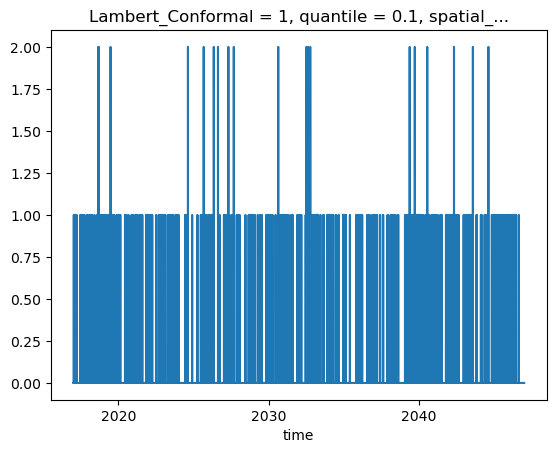

In [11]:
coincident_mask.plot()

In [12]:
# count the number of coincident drought events
coincident_events = xr.where(coincident_mask == 2, 1, 0)
num_coincident_events = coincident_events.sum().item()
print(f"Number of coincident drought events: {num_coincident_events}")

Number of coincident drought events: 23


Number of coincident drought events: 2


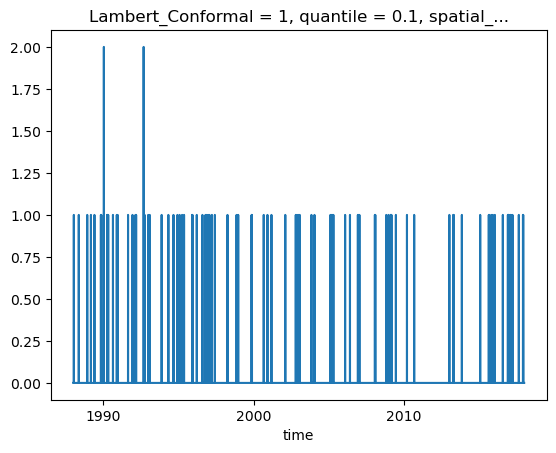

In [16]:
coincident_mask.plot()

# count the number of coincident drought events
coincident_events = xr.where(coincident_mask == 2, 1, 0)
num_coincident_events = coincident_events.sum().item()
print(f"Number of coincident drought events: {num_coincident_events}")